<a href="https://colab.research.google.com/github/prtk0007/Chest_Xray_detection/blob/exp_binary/Project_ray_6_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content"
# # !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
# ! kaggle datasets download -d pcbreviglieri/pneumonia-xray-images
# !unzip \*.zip

In [72]:
from keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.applications.resnet50 import ResNet50
#from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [73]:
IMAGE_SIZE = [180, 180]

# train_path = '/content/chest_xray/chest_xray/train'
# valid_path = '/content/chest_xray/chest_xray/test'

In [74]:
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [75]:
for layer in resnet.layers:
    layer.trainable = False

In [76]:
# folders = glob('/content/chest_xray/chest_xray/train/*')
# folders

In [77]:
from keras.layers import Dropout
x = Flatten(name='flatten')(resnet.output)
x = Dense(256, activation='relu', name='fc2')(x)
x = Dropout(0.4, name='drop2')(x)
x = Dense(256, activation='relu', name='fc3')(x)
x = Dropout(0.2, name='drop3')(x)
x = Dense(1, activation='sigmoid', name='predictions')(x)

In [78]:
model = Model(inputs=resnet.input, outputs=x)

In [79]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 186, 186, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 90, 90, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 90, 90, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [80]:
# from keras.optimizers import Adam
# opt = Adam(lr= 0.001)
model.compile(
  loss='binary_crossentropy',
  optimizer= 'adam',
  metrics=['accuracy']
)

In [81]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 30,
                                  zoom_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [82]:
training_set = train_datagen.flow_from_directory('/content/train',
                                                 target_size = (180, 180),
                                                 batch_size = 128,
                                                 class_mode = 'binary')

Found 4192 images belonging to 2 classes.


In [83]:
test_set = test_datagen.flow_from_directory('/content/test',
                                            target_size = (180, 180),
                                            batch_size = 128,
                                            shuffle=False,
                                            class_mode = 'binary')

Found 624 images belonging to 2 classes.


In [84]:
val_set = val_datagen.flow_from_directory('/content/val',
                                            target_size = (180, 180),
                                            batch_size = 128,
                                            class_mode = 'binary')

Found 1040 images belonging to 2 classes.


In [85]:
len(val_set)

9

In [86]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
early = EarlyStopping(monitor="val_accuracy", 
                      mode="max", 
                      patience=5)
callbacks_list = [ early ]

In [87]:
r = model.fit(
  training_set,
  validation_data=val_set,
  epochs=25,
  callbacks=callbacks_list
)

Epoch 1/15
33/33 [==============================] - 78s 2s/step - loss: 2.1597 - accuracy: 0.6973 - val_loss: 0.5231 - val_accuracy: 0.7433
Epoch 2/15
33/33 [==============================] - 73s 2s/step - loss: 0.5391 - accuracy: 0.7431 - val_loss: 0.4777 - val_accuracy: 0.7423
Epoch 3/15
33/33 [==============================] - 73s 2s/step - loss: 0.4650 - accuracy: 0.7574 - val_loss: 0.4329 - val_accuracy: 0.7731
Epoch 4/15
33/33 [==============================] - 73s 2s/step - loss: 0.4428 - accuracy: 0.7769 - val_loss: 0.4059 - val_accuracy: 0.7837
Epoch 5/15
33/33 [==============================] - 73s 2s/step - loss: 0.4082 - accuracy: 0.7889 - val_loss: 0.4379 - val_accuracy: 0.7577
Epoch 6/15
33/33 [==============================] - 73s 2s/step - loss: 0.3993 - accuracy: 0.8076 - val_loss: 0.3644 - val_accuracy: 0.8750
Epoch 7/15
33/33 [==============================] - 73s 2s/step - loss: 0.3740 - accuracy: 0.8203 - val_loss: 0.3523 - val_accuracy: 0.8875
Epoch 8/15
33/33 [==

In [88]:
model.evaluate(test_set)

5/5 [==============================] - 5s 784ms/step - loss: 0.4057 - accuracy: 0.8365


[0.4056791365146637, 0.8365384340286255]

In [ ]:
model.evaluate(val_set)

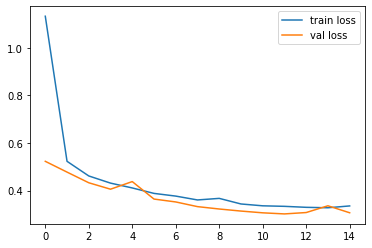

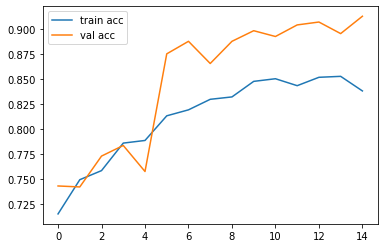

<Figure size 432x288 with 0 Axes>

In [89]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
test_accu = model.evaluate(test_set)
print('The testing accuracy is :',test_accu[1]*100, '%')

39/39 [==============================] - 50s 1s/step - loss: 0.3132 - accuracy: 0.9119
The testing accuracy is : 91.18589758872986 %


In [ ]:
preds = model.predict(test_set,verbose=1)

In [ ]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

cm = pd.DataFrame(data=confusion_matrix(test_set.classes, predictions, labels=[0, 1]),
                  index=["Actual Normal", "Actual Pneumonia"],
                  columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
 print(classification_report(y_true=test_set.classes, y_pred=predictions,
                            target_names =['NORMAL','PNEUMONIA']
 ))

              precision    recall  f1-score   support

      NORMAL       0.95      0.81      0.87       234
   PNEUMONIA       0.90      0.97      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.89      0.90       624
weighted avg       0.91      0.91      0.91       624



In [ ]:
import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize

In [ ]:
TRAIN_DIR = "/content/chest_xray/chest_xray/train/"
TEST_DIR =  "/content/chest_xray/chest_xray/test/"

In [ ]:
def get_label(Dir):
    for nextdir in os.listdir(Dir):
        if not nextdir.startswith('.'):
            if nextdir in ['NORMAL']:
                label = 0
            elif nextdir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
    return nextdir, label

In [ ]:
def preprocessing_data(Dir):
    X = []
    y = []
    
    for nextdir in os.listdir(Dir):
        nextdir, label = get_label(Dir)
        temp = Dir + nextdir
        
        for image_filename in tqdm(os.listdir(temp)):
            path = os.path.join(temp + '/' , image_filename)
            img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = skimage.transform.resize(img, (180, 180, 3))
                img = np.asarray(img)
                X.append(img)
                y.append(label)
            
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X,y

In [ ]:
def get_data(Dir):
    X = []
    y = []
    for nextDir in os.listdir(Dir):
        if not nextDir.startswith('.'):
            if nextDir in ['NORMAL']:
                label = 0
            elif nextDir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
                
            temp = Dir + nextDir
                
            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (180, 180, 3))
                    #img_file = scipy.misc.imresize(arr=img_file, size=(150, 150, 3))
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [ ]:
X_test , y_test = get_data(TEST_DIR)

100%|██████████| 234/234 [01:38<00:00,  2.38it/s]


In [ ]:
from keras.utils.np_utils import to_categorical
y_test = to_categorical(y_test, 2)


In [ ]:
print(y_test.shape)

(624, 2)


In [ ]:
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

In [ ]:
pred

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,

In [ ]:
y_true

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

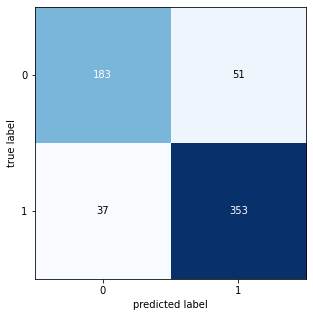

In [ ]:
cm = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5))
plt.show()

In [ ]:
print('True Positive  (TP) = ', cm[1][1])
print('False Positive (FP) = ', cm[0][1])
print('False Negative (FN) = ', cm[1][0])
print('True Negative  (TN) = ', cm[0][0])
print('-'*26)

True Positive  (TP) =  353
False Positive (FP) =  51
False Negative (FN) =  37
True Negative  (TN) =  183
--------------------------


In [ ]:
if (cm[0][0] + cm[0][1])!=0 and (cm[0][0], cm[1][0])!=0:
      precision= round((cm[0][0] / (cm[0][0] + cm[0][1]))*100, 2) 
      recall   = round((cm[0][0] / (cm[0][0] + cm[1][0]))*100, 2) 
      f1_score = round(2*((precision*recall)/(precision+recall)), 2)       
      print(f'Precision Score: {precision}%')
      print(f'Recall Score: {recall}%')
      print(f'F1 Score: {f1_score}%')
      print('='*50) 
      print('\n')

Precision Score: 78.21%
Recall Score: 83.18%
F1 Score: 80.62%




Actual class:  PNEUMONIA
Predicted class: Pneumonia


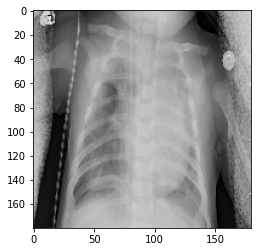

In [ ]:
path = '/content/chest_xray/chest_xray/test/PNEUMONIA/person100_bacteria_478.jpeg'
actual= os.path.basename(os.path.dirname(path))
img = image.load_img(path, target_size=(180,180))
plt.imshow(img)
x=image.img_to_array(img)
x=np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)
print("Actual class: ", actual)
if classes[0][0] > 0.8:
        print("Predicted class: Normal")
else:
        print("Predicted class: Pneumonia")

In [ ]:
classes

array([[1.6489543e-05, 9.9998355e-01]], dtype=float32)